# 序列模型

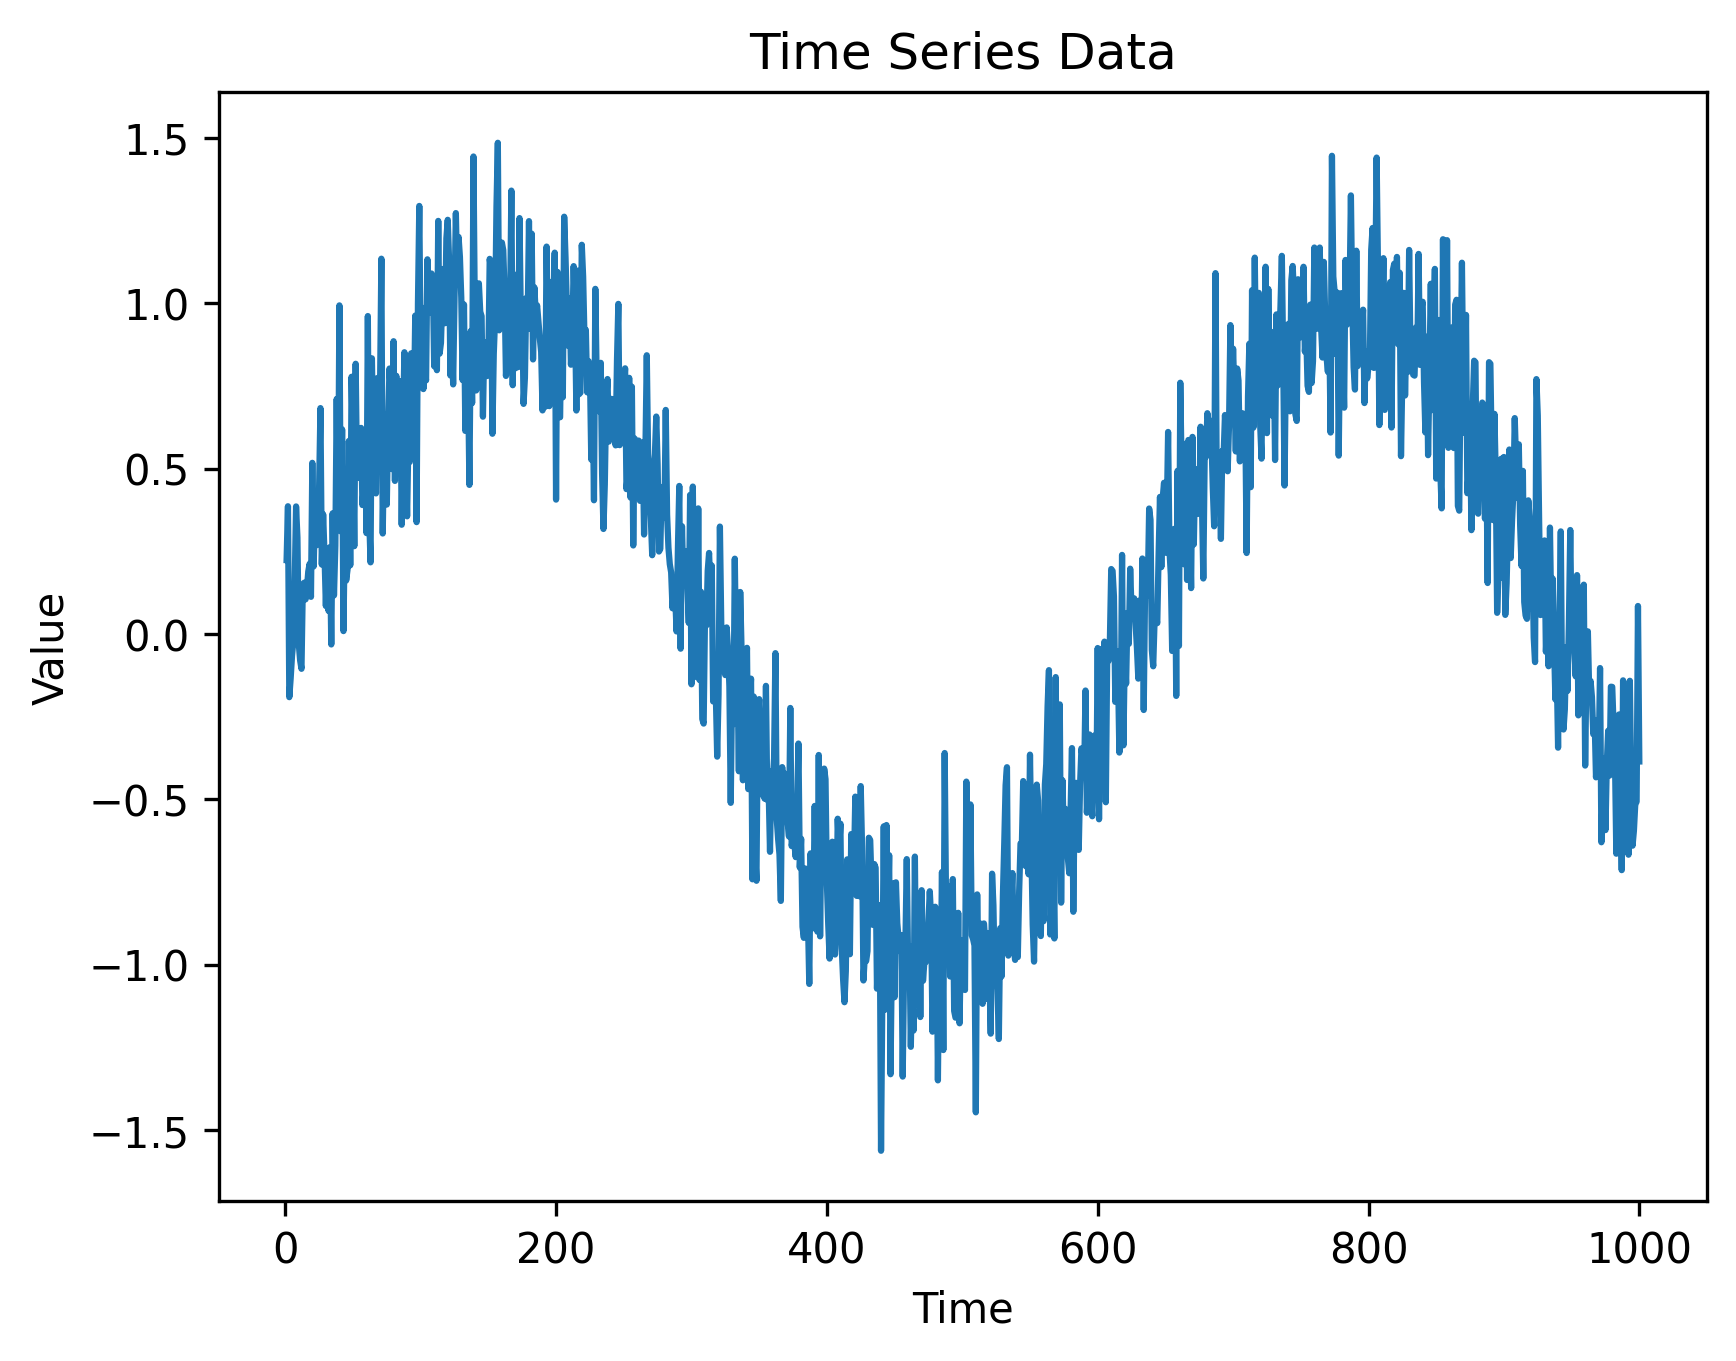

In [4]:
import torch
from torch import nn

T = 1000  # 总共产生1000个点
time = torch.arange(1, T+1, dtype=torch.float32)  # 时间序列
x = torch.sin(time / 100) + torch.normal(0, 0.2, (T, ))

# 绘图
import matplotlib.pyplot as plt
#  设置分辨率
plt.rcParams['figure.dpi'] = 300
plt.plot(time, x)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

In [5]:
# 构建特征和标签
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape(-1, 1)

# 划分训练集和测试集
batch_size = 16
train_size = 600

train_data = torch.utils.data.TensorDataset(features[:train_size], labels[:train_size])
test_data = torch.utils.data.TensorDataset(features[train_size:], labels[train_size:])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [7]:
def evaluate_loss(net, data_iter, loss):
    metric = 0.0
    for X, y in data_iter:
        metric += loss(net(X), y).sum().item()
    return metric / len(data_iter.dataset)

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_loader, loss, 5, 0.01)

# epoch 1, loss: 0.073380
# epoch 2, loss: 0.057079
# epoch 3, loss: 0.054938
# epoch 4, loss: 0.053320
# epoch 5, loss: 0.055273

epoch 1, loss: 0.219312
epoch 2, loss: 0.060027
epoch 3, loss: 0.054213
epoch 4, loss: 0.051347
epoch 5, loss: 0.051872


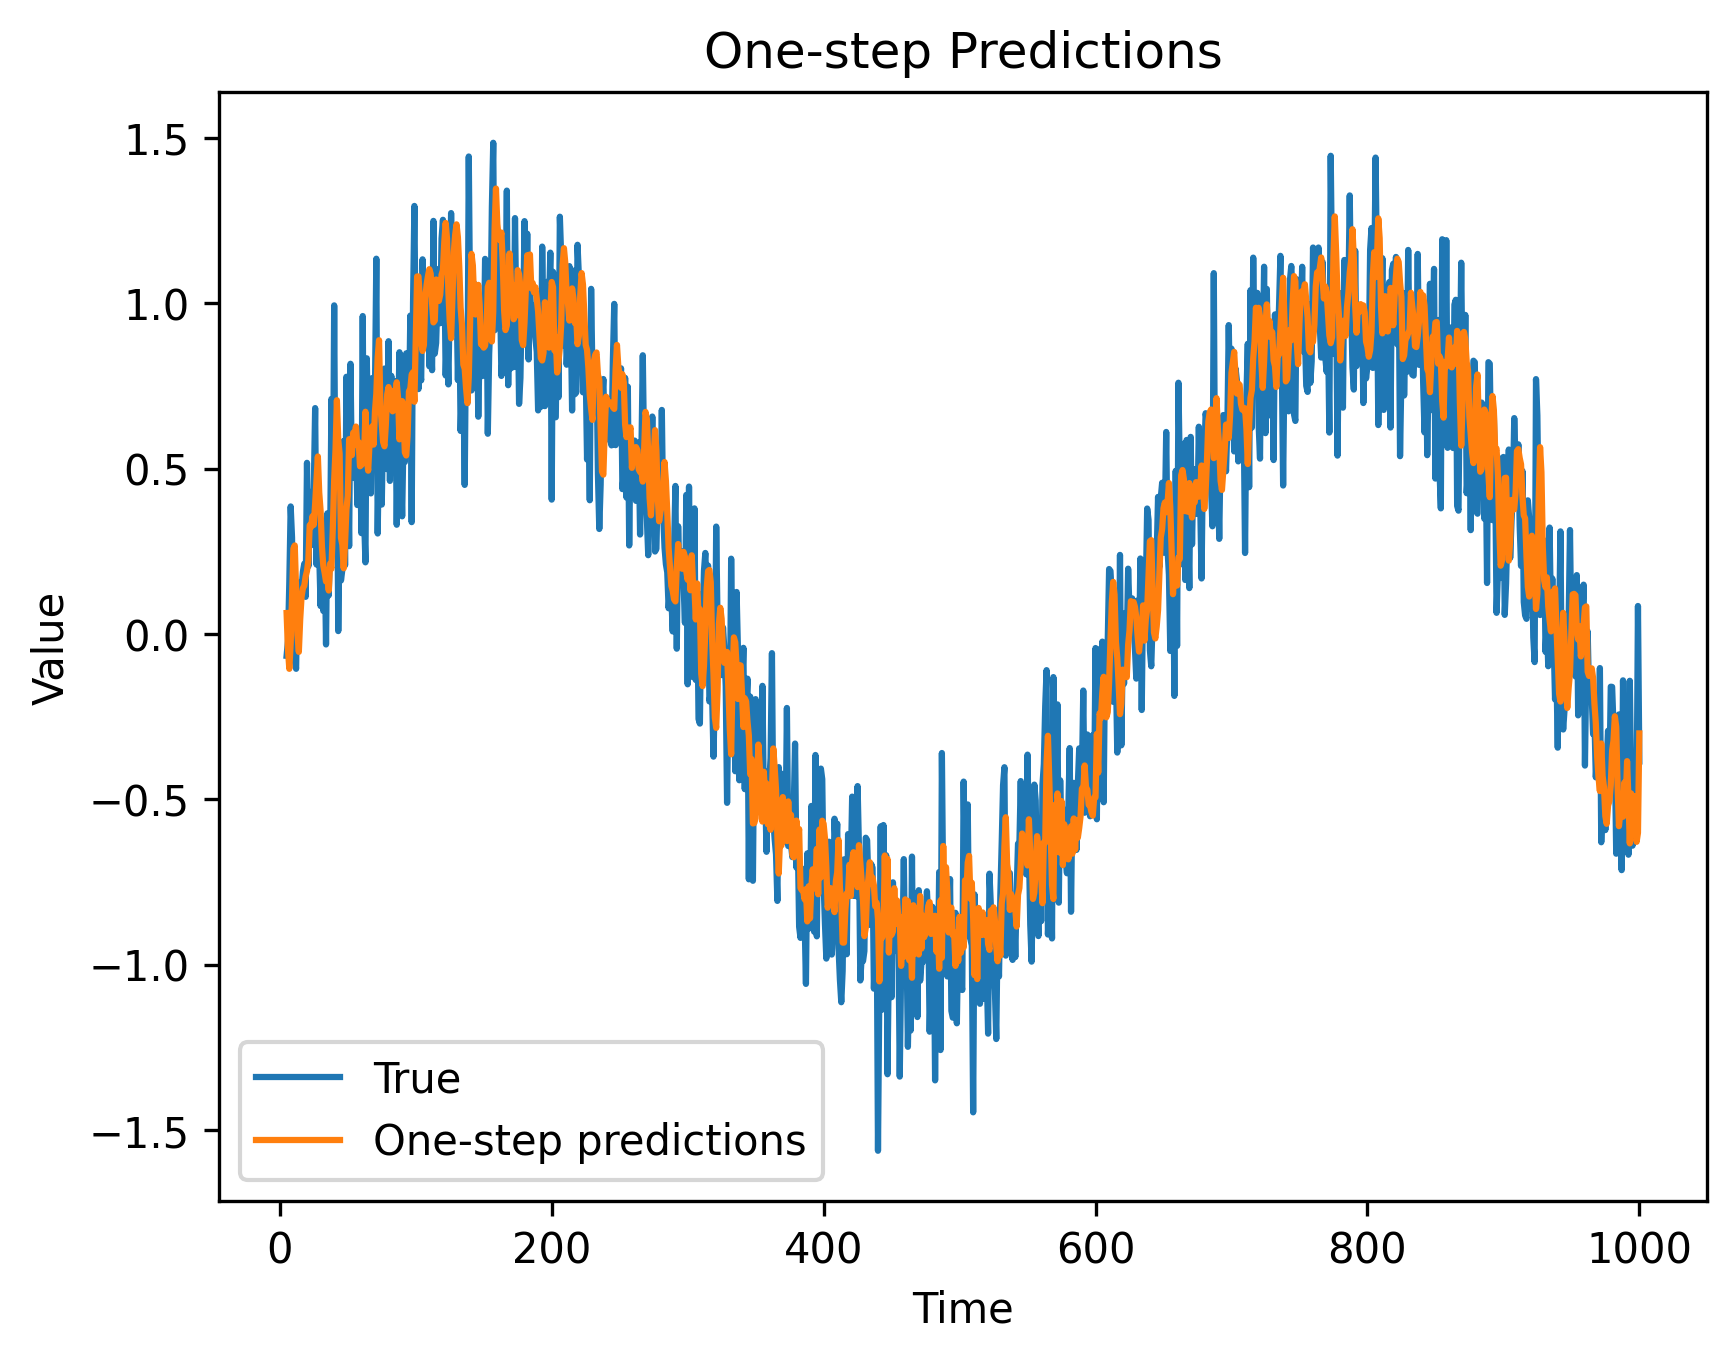

In [8]:
onestep_preds = net(features)

# 绘图
plt.figure()
plt.plot(time[tau:], labels, label='True')
plt.plot(time[tau:], onestep_preds.detach(), label='One-step predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('One-step Predictions')
plt.legend()
plt.show()

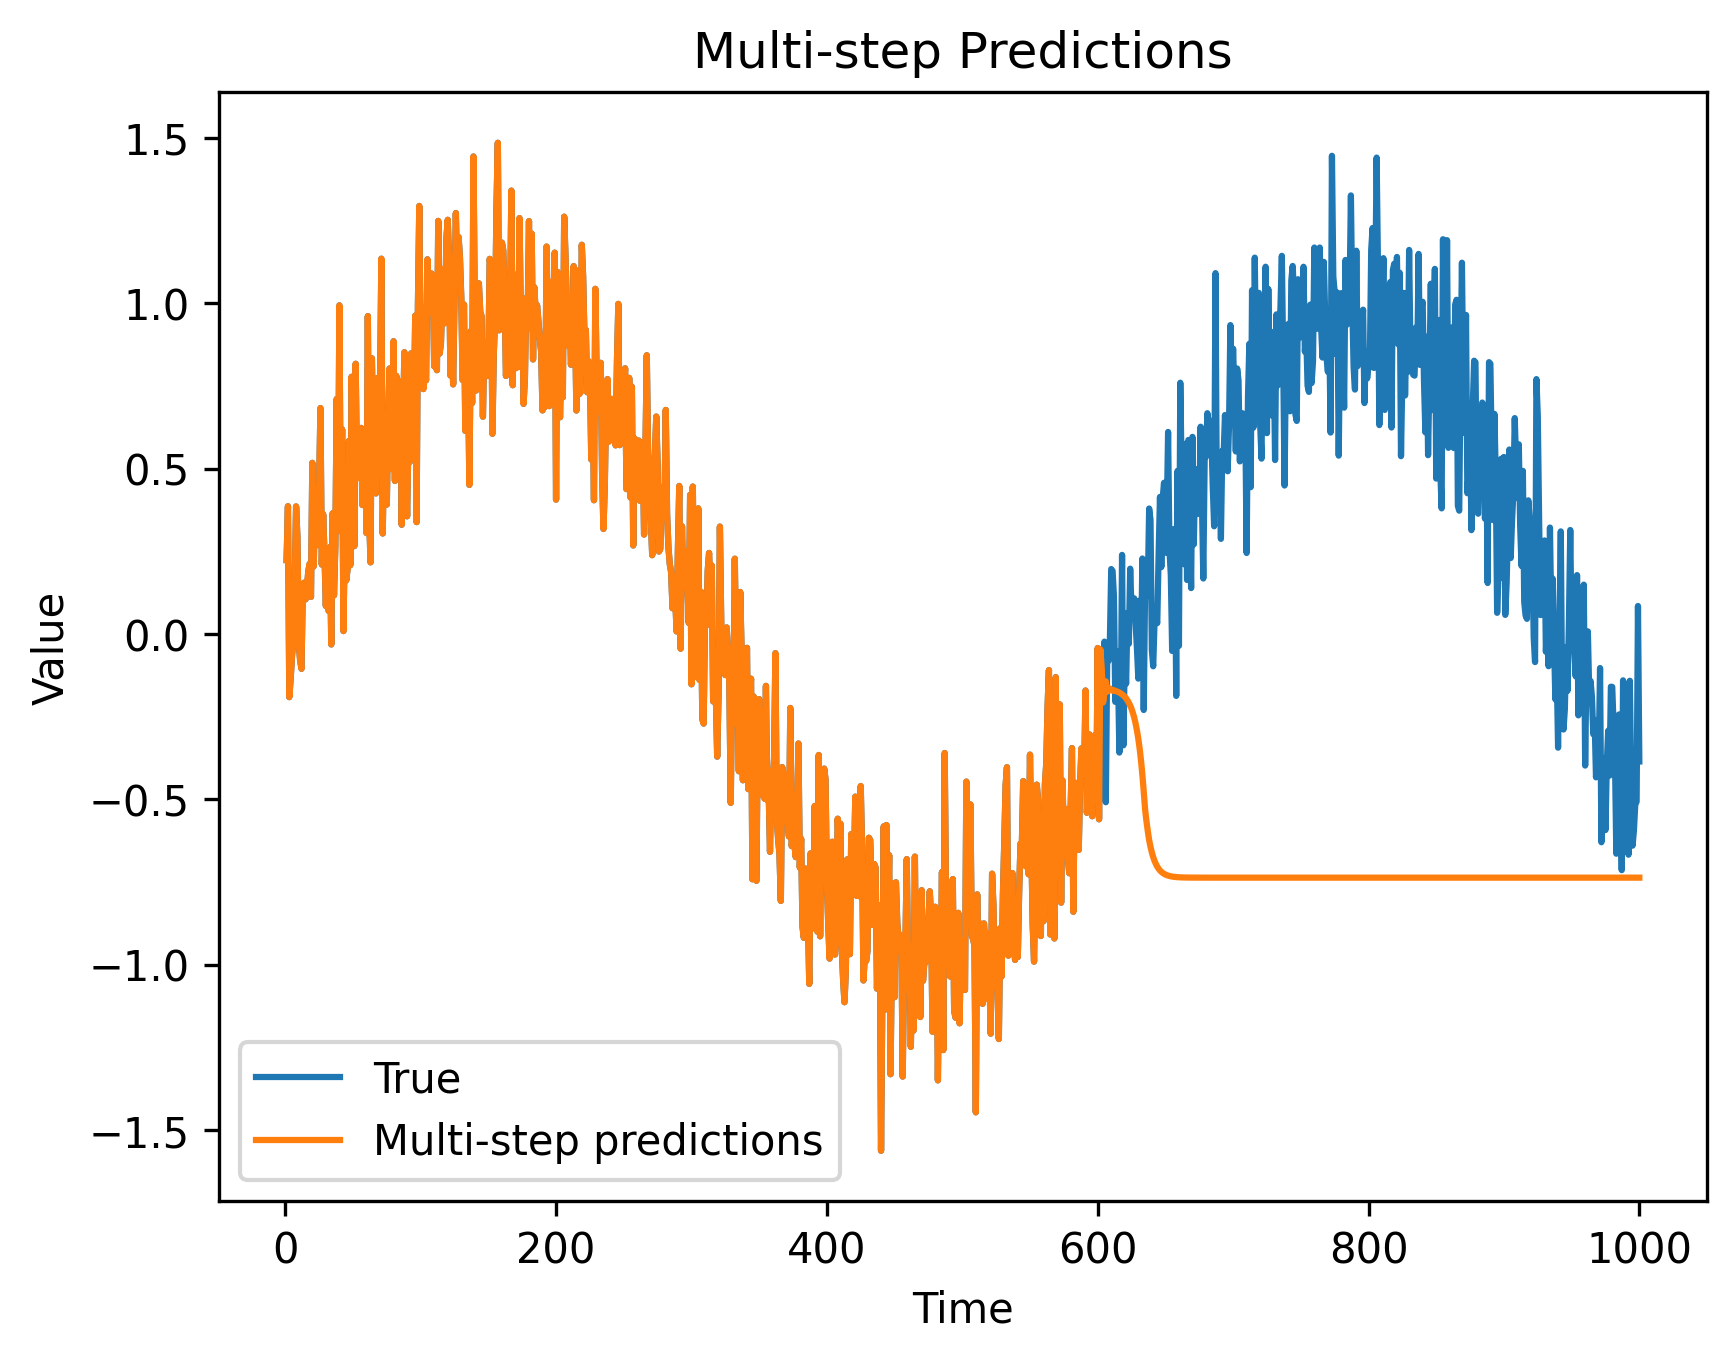

In [9]:
multistep_preds = torch.zeros(T)
multistep_preds[: train_size + tau] = x[: train_size + tau]
for i in range(train_size + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

# 绘图（多步预测+真实值）
plt.figure()
plt.plot(time, x, label='True')
plt.plot(time, multistep_preds.detach(), label='Multi-step predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Multi-step Predictions')
plt.legend()
plt.show()

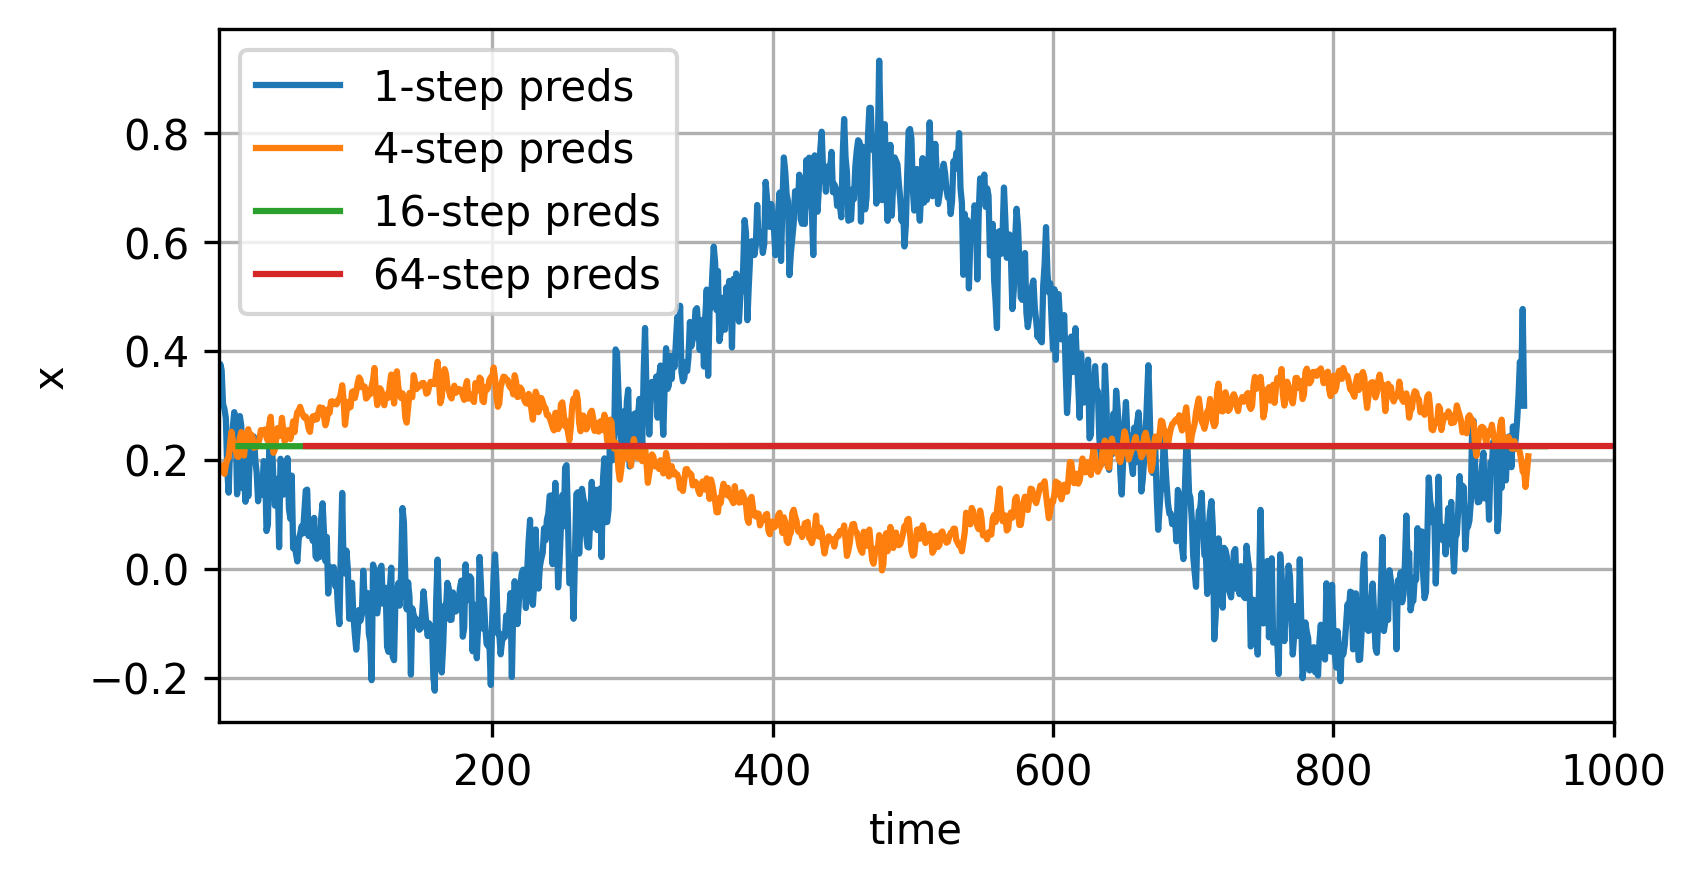

In [10]:
import torch
import matplotlib.pyplot as plt

# --- 您需要提供的部分（用示例值代替）---
# 假设这些变量已经定义好了
T = 1000  # 总时间步数
tau = 4   # 时间窗口大小
# 假设 x 是一个包含T个点的PyTorch张量，代表时间序列数据
x = torch.sin(torch.arange(0, T, dtype=torch.float32) * 0.01) + torch.randn(T) * 0.2
# 假设 time 是一个包含T个点的PyTorch张量，代表时间戳
time = torch.arange(0, T, dtype=torch.float32)
# 假设 net 是一个已经训练好的PyTorch模型 (nn.Module)
# 这里我们用一个简单的线性模型作为示例
net = torch.nn.Linear(tau, 1) 
# --- 示例部分结束 ---


# 您的预测逻辑代码（保持不变）
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

# 填充历史数据
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 自回归预测
for i in range(tau, tau + max_steps):
    # 将输入转换为正确的形状 [batch_size, sequence_length]
    net_input = features[:, i - tau:i]
    features[:, i] = net(net_input).reshape(-1)


# --- 使用 Matplotlib 替换 d2l.plot ---

# 1. 准备绘图所需的数据
steps = (1, 4, 16, 64)
plot_time = [time[tau + i - 1: T - max_steps + i] for i in steps]
plot_features = [features[:, (tau + i - 1)].detach().numpy() for i in steps]
legend_labels = [f'{i}-step preds' for i in steps]

# 2. 开始绘图
# 创建一个图形和一组坐标轴，并设置图形大小
fig, ax = plt.subplots(figsize=(6, 3))

# 循环绘制每一条预测线
for t, f, label in zip(plot_time, plot_features, legend_labels):
    ax.plot(t, f, label=label)

# 3. 设置图表的各种属性
ax.set_xlabel('time')  # 设置 x 轴标签
ax.set_ylabel('x')     # 设置 y 轴标签
ax.set_xlim([5, 1000])  # 设置 x 轴的显示范围
ax.grid(True)          # 添加网格线，方便查看
ax.legend()            # 显示图例

# 4. 显示图形
plt.show()

In [11]:
for i in [time[tau + i - 1: T - max_steps + i] for i in steps]:
    print(i.shape)

torch.Size([933])
torch.Size([933])
torch.Size([933])
torch.Size([933])


In [12]:
import collections
import re

# 文本预处理

In [13]:
import os
import re
import hashlib
import urllib.request

# --- 1. 手动定义数据源信息 ---
# 之前由 d2l.DATA_HUB 和 d2l.DATA_URL 管理
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

# --- 执行并展示结果（与原代码完全相同）---
lines = read_time_machine()
if lines:
    print(f'\n# 文本总行数: {len(lines)}')
    print(lines[0])
    print(lines[10])

# 正在从 http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt 下载 timemachine.txt...
# timemachine.txt 校验成功！

# # 文本总行数: 3221
# the time machine by h g wells
# twinkled and his usually pale face was flushed and animated the

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [14]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

# ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
# []
# []
# []
# []
# ['i']
# []
# []
# ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
# ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
# ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [18]:
print(tokens[1:10])

[[], [], [], [], ['i'], [], [], ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him'], ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']]


In [19]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

# [('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [ ]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

# 文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
# 索引: [1, 19, 50, 40, 2183, 2184, 400]
# 文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
# 索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [ ]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

# (170580, 28)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


(170580, 28)

In [ ]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines)
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
print('前10个词元索引:', vocab.token_freqs[:10])

# timemachine.txt 已存在，跳过下载。
# timemachine.txt 校验成功！
# 前10个词元索引: [('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！
前10个词元索引: [('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


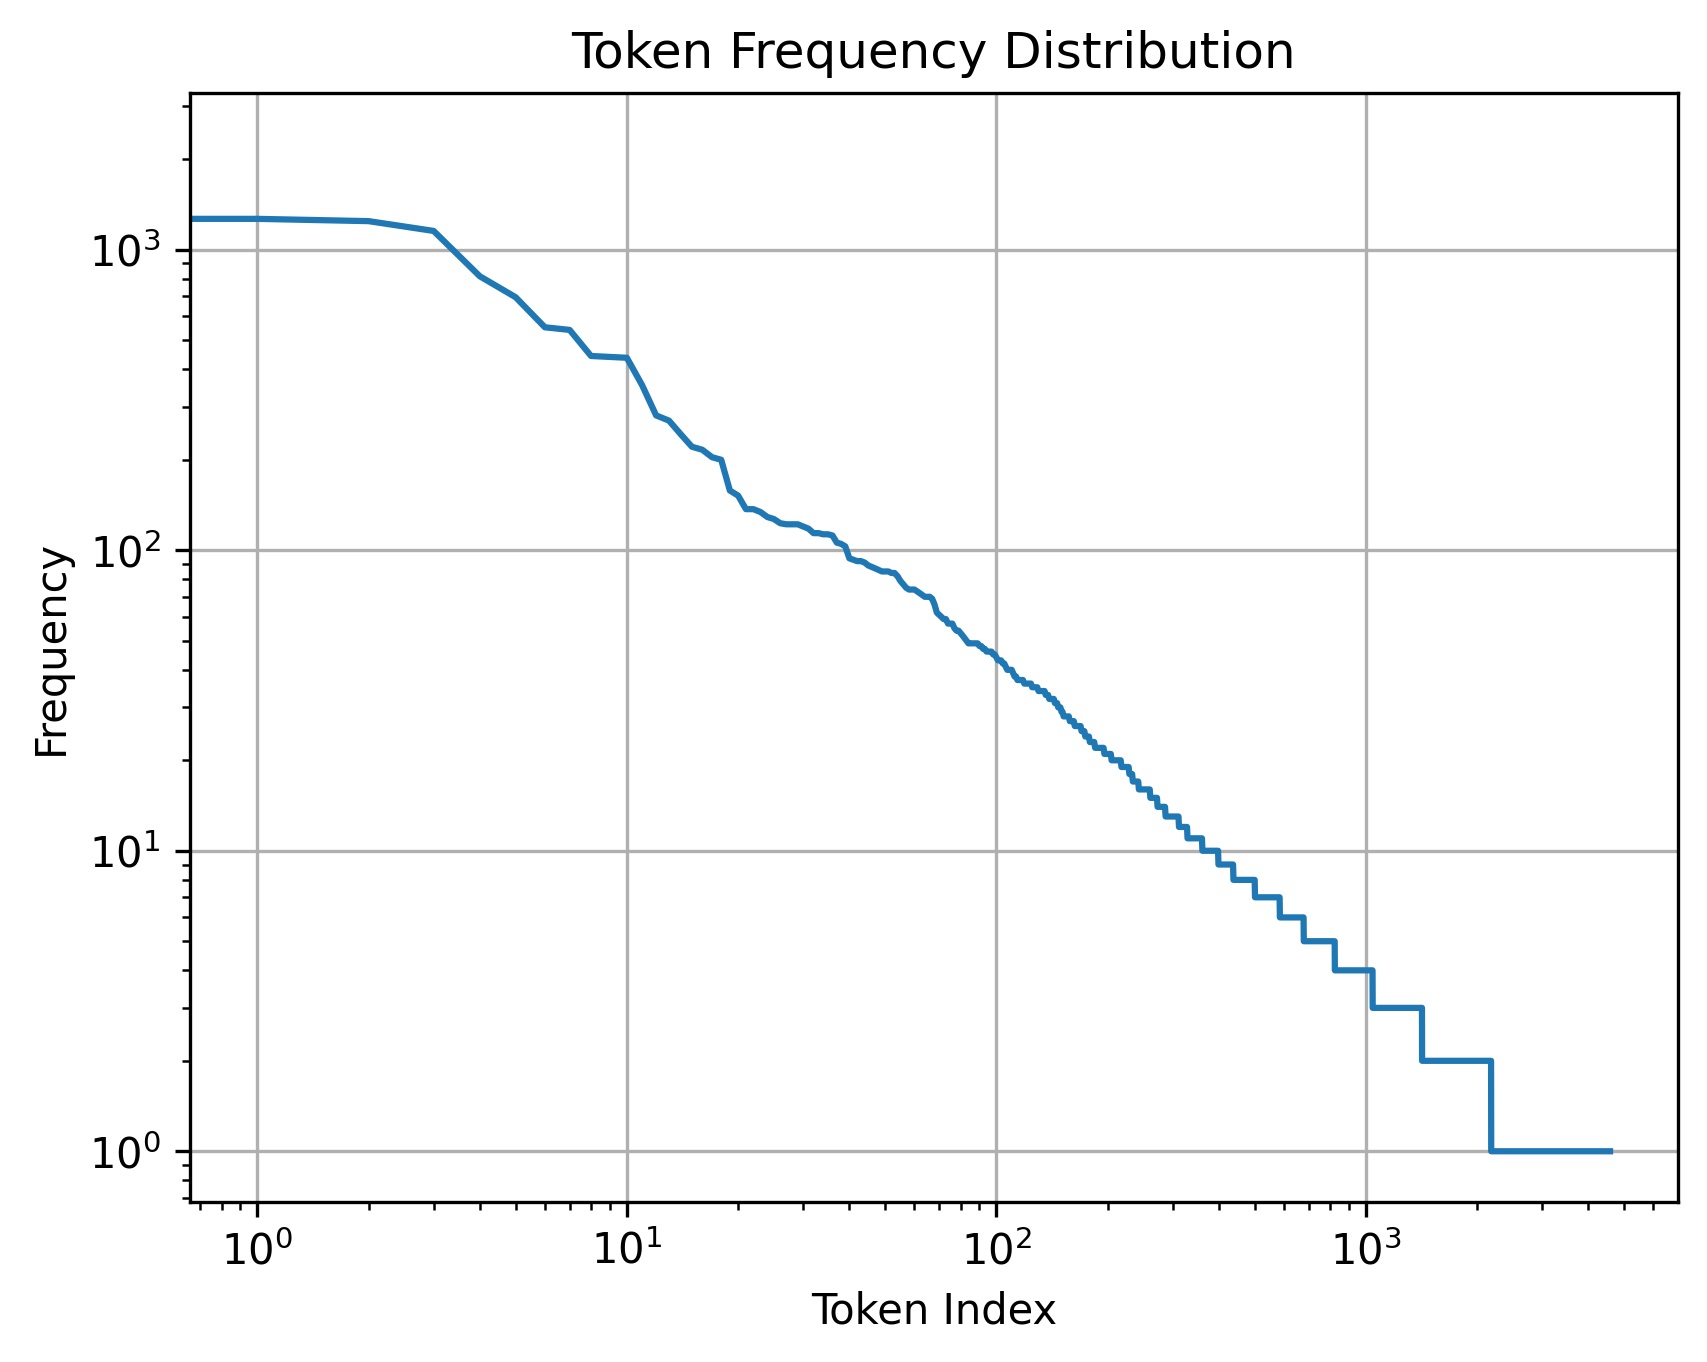

In [30]:
freqs = [freq for token, freq in vocab.token_freqs]
# 绘制词频分布图
plt.figure()
plt.plot(range(len(freqs)), freqs)
plt.xlabel('Token Index')
plt.ylabel('Frequency')
plt.title('Token Frequency Distribution')
plt.xscale('log')  # x轴对数刻度
plt.yscale('log')  # y轴对数刻度
plt.grid(True)
plt.show()

In [32]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
# 查看最频繁的二元组对应的实际词元
for (idx1, idx2), freq in bigram_vocab.token_freqs[:10]:
    word1 = vocab.to_tokens(idx1)
    word2 = vocab.to_tokens(idx2)
    print(f"('{word1}', '{word2}') 出现 {freq} 次")

# # 查看最频繁的二元组对应的实际词元
# for (idx1, idx2), freq in bigram_vocab.token_freqs[:5]:
#     word1 = vocab.to_tokens(idx1)
#     word2 = vocab.to_tokens(idx2)
#     print(f"('{word1}', '{word2}') 出现 {freq} 次")

('of', 'the') 出现 309 次
('in', 'the') 出现 169 次
('i', 'had') 出现 130 次
('i', 'was') 出现 112 次
('and', 'the') 出现 109 次
('the', 'time') 出现 102 次
('it', 'was') 出现 99 次
('to', 'the') 出现 85 次
('as', 'i') 出现 78 次
('of', 'a') 出现 73 次


In [ ]:
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
# 查看最频繁的三元组对应的实际词元
for (idx1, idx2, idx3), freq in trigram_vocab.token_freqs[:10]:
    word1 = vocab.to_tokens(idx1)
    word2 = vocab.to_tokens(idx2)
    word3 = vocab.to_tokens(idx3)
    print(f"('{word1}', '{word2}', '{word3}') 出现 {freq} 次")

#     ('the', 'time', 'traveller') 出现 59 次
# ('the', 'time', 'machine') 出现 30 次
# ('the', 'medical', 'man') 出现 24 次
# ('it', 'seemed', 'to') 出现 16 次
# ('it', 'was', 'a') 出现 15 次
# ('here', 'and', 'there') 出现 15 次
# ('seemed', 'to', 'me') 出现 14 次
# ('i', 'did', 'not') 出现 14 次
# ('i', 'saw', 'the') 出现 13 次
# ('i', 'began', 'to') 出现 13 次

('the', 'time', 'traveller') 出现 59 次
('the', 'time', 'machine') 出现 30 次
('the', 'medical', 'man') 出现 24 次
('it', 'seemed', 'to') 出现 16 次
('it', 'was', 'a') 出现 15 次
('here', 'and', 'there') 出现 15 次
('seemed', 'to', 'me') 出现 14 次
('i', 'did', 'not') 出现 14 次
('i', 'saw', 'the') 出现 13 次
('i', 'began', 'to') 出现 13 次


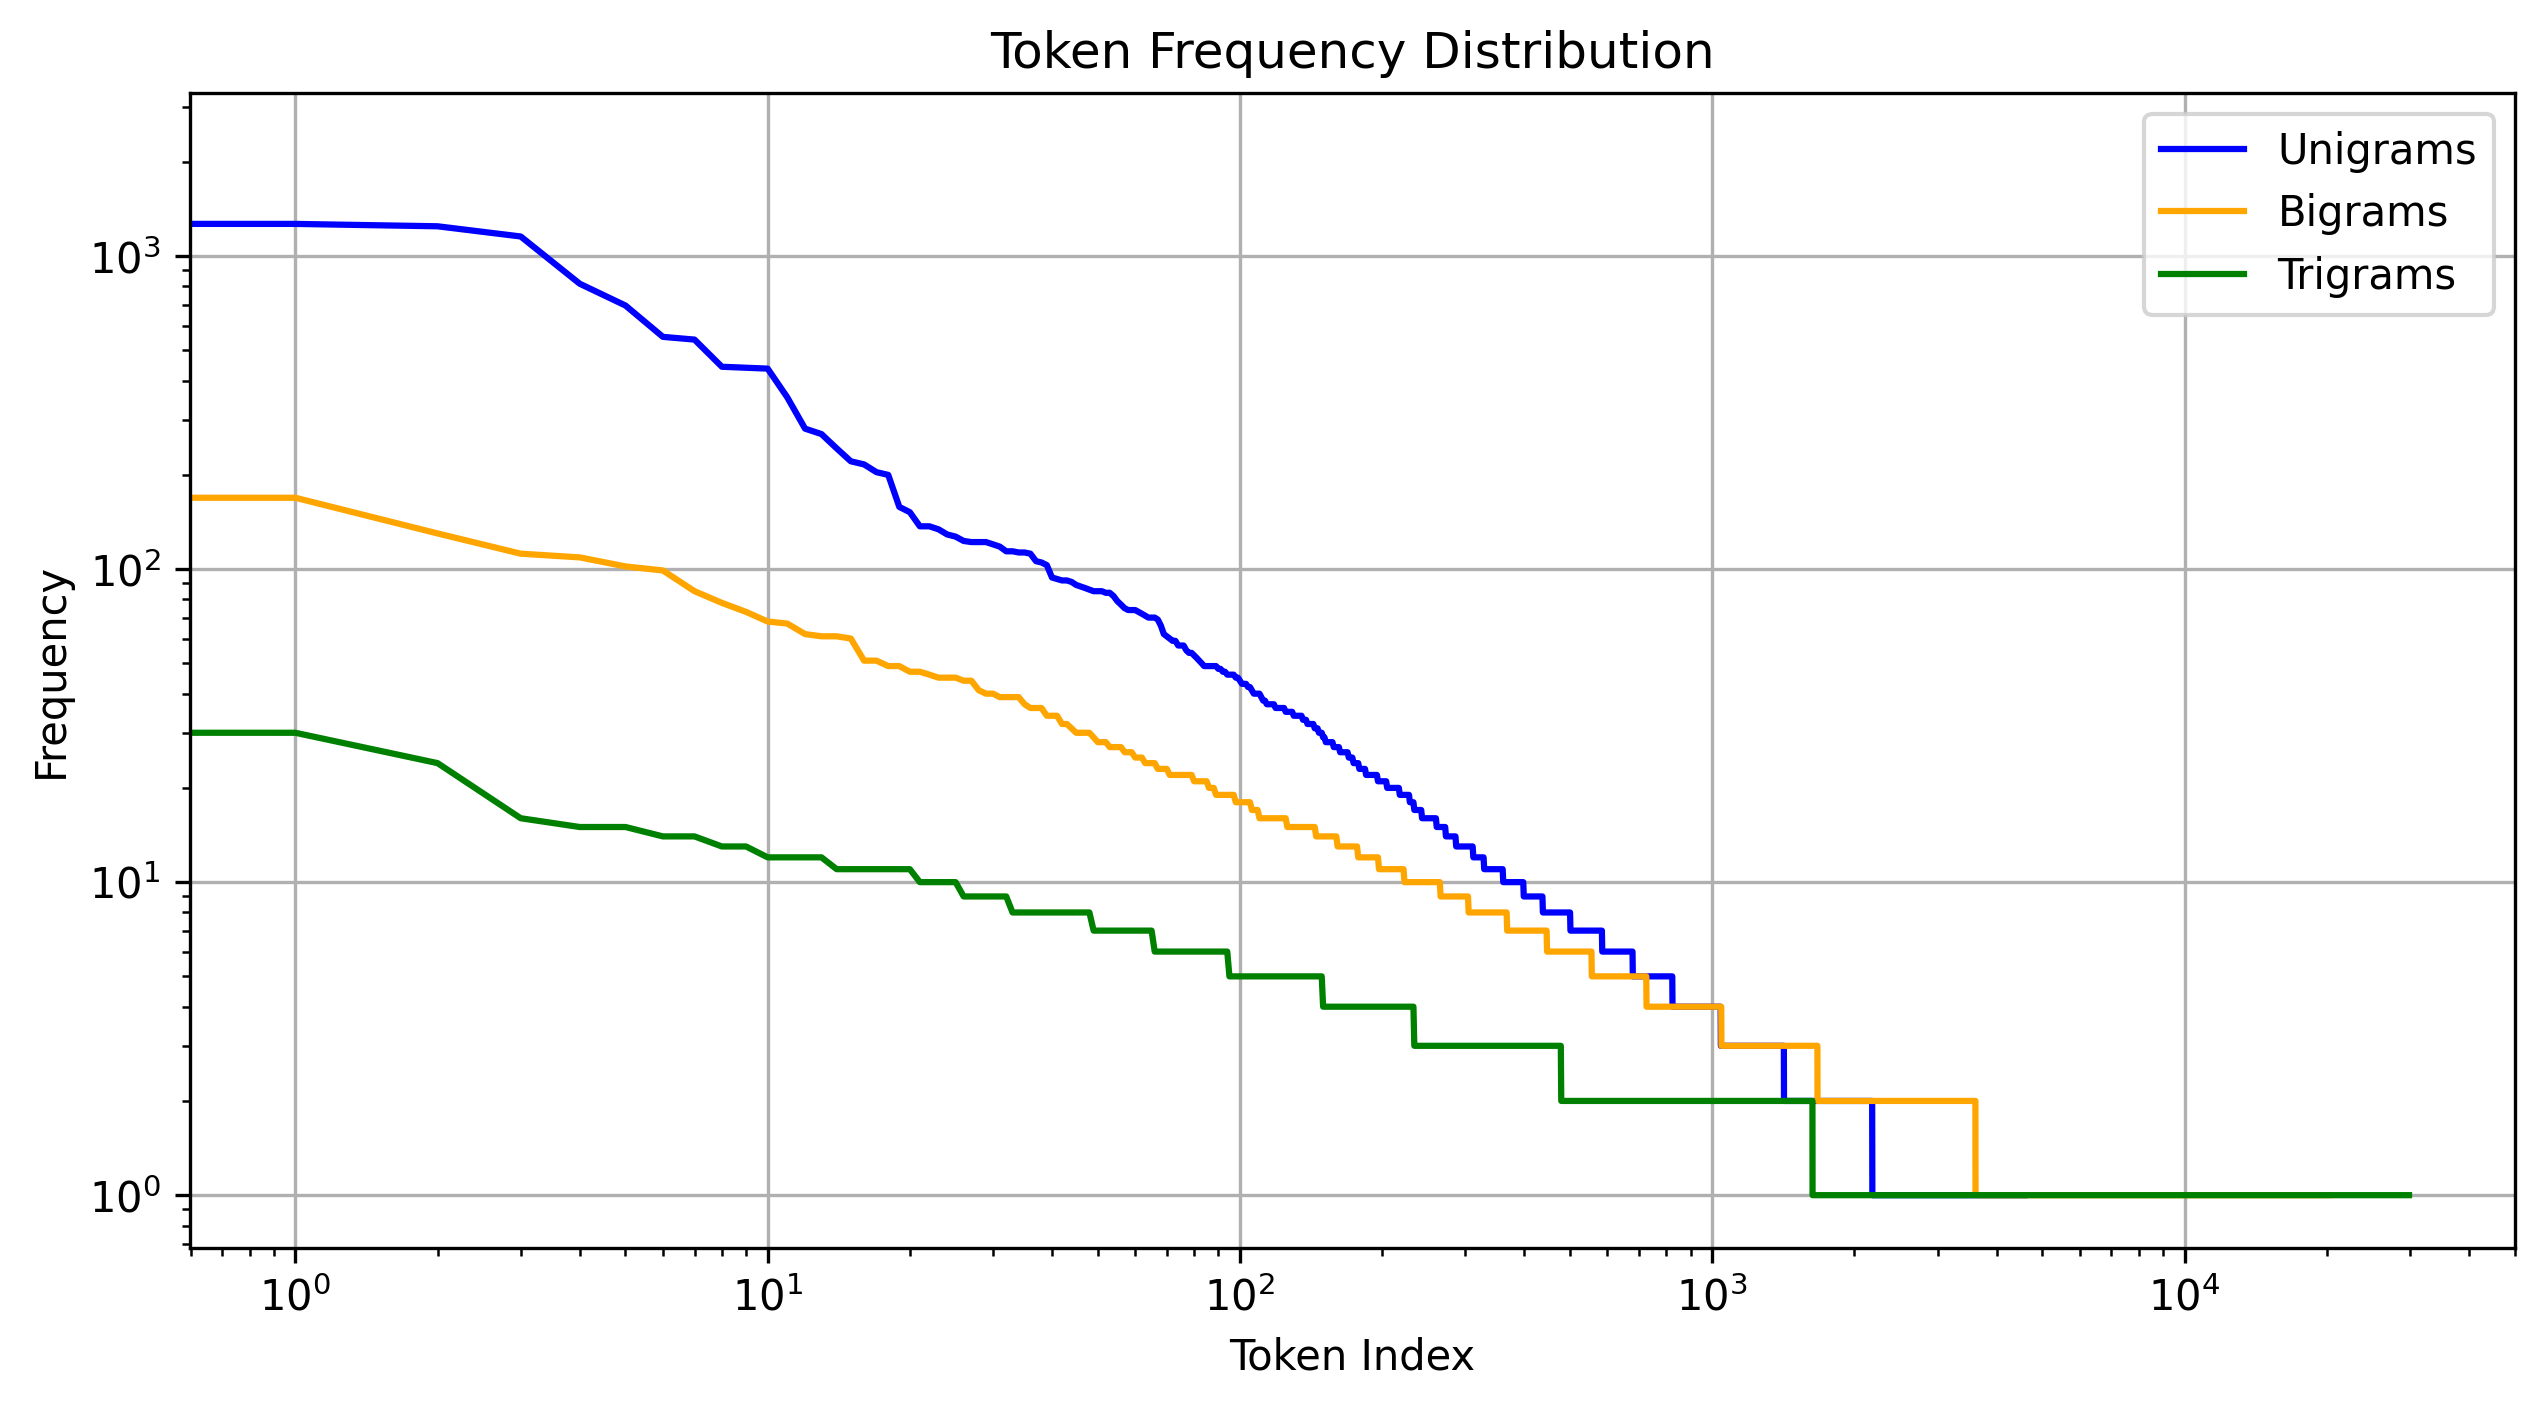

In [41]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# 一幅图绘制三种词元的频率分布图（不用子图）
plt.figure(figsize=(10, 5))
plt.plot(range(len(freqs)), freqs, label='Unigrams', color='blue')
plt.plot(range(len(bigram_freqs)), bigram_freqs, label='Bigrams', color='orange')
plt.plot(range(len(trigram_freqs)), trigram_freqs, label='Trigrams', color='green')
plt.xlabel('Token Index')
plt.ylabel('Frequency')
plt.title('Token Frequency Distribution')  
plt.xscale('log')  # x轴对数刻度
plt.yscale('log')  # y轴对数刻度
plt.grid(True)
plt.legend()
plt.show()

In [43]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

# X:  tensor([[26, 27, 28, 29, 30],
#         [ 1,  2,  3,  4,  5]]) 
# Y: tensor([[27, 28, 29, 30, 31],
#         [ 2,  3,  4,  5,  6]])
# X:  tensor([[ 6,  7,  8,  9, 10],
#         [21, 22, 23, 24, 25]]) 
# Y: tensor([[ 7,  8,  9, 10, 11],
#         [22, 23, 24, 25, 26]])
# X:  tensor([[11, 12, 13, 14, 15],
#         [16, 17, 18, 19, 20]]) 
# Y: tensor([[12, 13, 14, 15, 16],
#         [17, 18, 19, 20, 21]])

X:  tensor([[26, 27, 28, 29, 30],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [22, 23, 24, 25, 26]])
X:  tensor([[11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [17, 18, 19, 20, 21]])


In [46]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [ ]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

# X:  tensor([[ 5,  6,  7,  8,  9],
#         [19, 20, 21, 22, 23]]) 
# Y: tensor([[ 6,  7,  8,  9, 10],
#         [20, 21, 22, 23, 24]])
# X:  tensor([[10, 11, 12, 13, 14],
#         [24, 25, 26, 27, 28]]) 
# Y: tensor([[11, 12, 13, 14, 15],
#         [25, 26, 27, 28, 29]])

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [49]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [50]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 循环神经网络

In [ ]:
import torch

X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

# tensor([[ 1.2646,  0.5208, -3.1248,  1.8223],
#         [ 4.8379,  2.4361, -0.4848,  0.7028],
#         [-3.1858,  2.1389, -2.6562, -0.7278]])

tensor([[ 1.2646,  0.5208, -3.1248,  1.8223],
        [ 4.8379,  2.4361, -0.4848,  0.7028],
        [-3.1858,  2.1389, -2.6562, -0.7278]])

In [ ]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

# tensor([[ 1.2646,  0.5208, -3.1248,  1.8223],
#         [ 4.8379,  2.4361, -0.4848,  0.7028],
#         [-3.1858,  2.1389, -2.6562, -0.7278]])

tensor([[ 1.2646,  0.5208, -3.1248,  1.8223],
        [ 4.8379,  2.4361, -0.4848,  0.7028],
        [-3.1858,  2.1389, -2.6562, -0.7278]])

# 循环神经网络的从零开始实现

In [5]:
import os
import re
import hashlib
import urllib.request
import collections


DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [6]:
import math
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

# tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#          0, 0, 0, 0],
#         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#          0, 0, 0, 0]])

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

# torch.Size([5, 2, 28])

torch.Size([5, 2, 28])

In [9]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [10]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [11]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [12]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [15]:
num_hiddens = 512
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], device)
Y, new_state = net(X.to(device), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [17]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [ ]:
predict_ch8('time traveller ', 10, net, vocab, device)

# 'time traveller bscxnzihwm'

'time traveller bscxnzihwm'

In [19]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    # 定义

# 间接实现

In [1]:
import os
import re
import hashlib
import urllib.request
import collections


DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [2]:
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [3]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [4]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

# torch.Size([1, 32, 256])

torch.Size([1, 32, 256])

In [5]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

# (torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [6]:
#@save
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

开始在 mps 上训练...
Epoch 10, Perplexity 11.2, Speed 73351.9 tokens/sec
  预测 'time traveller': time traveller an an an an an an an an an an an an an an an an a
Epoch 20, Perplexity 9.3, Speed 34949.6 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 30, Perplexity 8.5, Speed 67678.3 tokens/sec
  预测 'time traveller': time travellerat and he and he and he and he and he and he and h
Epoch 40, Perplexity 7.7, Speed 66911.7 tokens/sec
  预测 'time traveller': time travellerthes of that moveracont and the thace the that the
Epoch 50, Perplexity 7.4, Speed 67308.1 tokens/sec
  预测 'time traveller': time traveller andithe the prace thice and he the thise sime sio
Epoch 60, Perplexity 7.1, Speed 77334.6 tokens/sec
  预测 'time traveller': time traveller the medin thi g an that that that that that that 
Epoch 70, Perplexity 6.3, Speed 74817.5 tokens/sec
  预测 'time traveller': time traveller theer dimensions and thee the m the g aid the med
Epoch 80, P

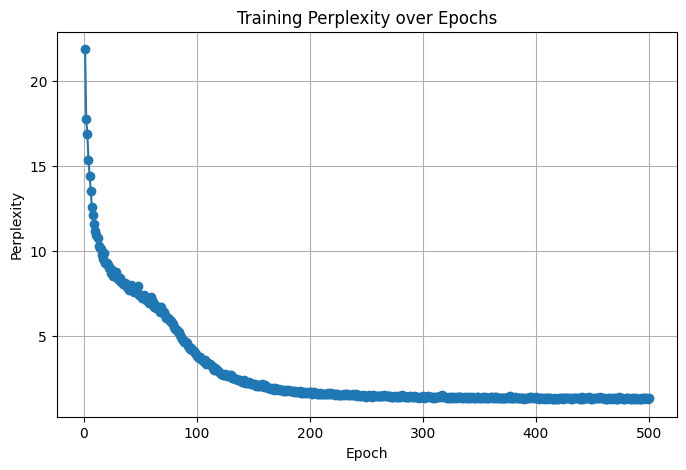

In [7]:
import torch
import torch.nn as nn
import math
import time
import matplotlib.pyplot as plt

# ==================================================================
# 1. 必需的辅助函数 (替代 d2l 的功能)
# ==================================================================

def grad_clipping(net, theta):
    """裁剪梯度 (使用PyTorch内置函数实现)"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
        torch.nn.utils.clip_grad_norm_(params, theta)

def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    # 将网络设置为评估模式
    net.eval()
    # 初始化隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    # 将前缀文本转换为数字索引
    outputs = [vocab[prefix[0]]]
    # 预热阶段：用前缀来更新隐藏状态
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 预测阶段：生成 num_preds 个新字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    # 将生成的数字索引转换回文本
    return ''.join([vocab.to_tokens(i) for i in outputs])

# ==================================================================
# 2. 合并后的主训练函数
# ==================================================================

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
                         use_random_iter=False):
    """
    训练语言模型 (不依赖d2l库的整合版本)

    :param net: 神经网络模型 (nn.Module)
    :param train_iter: 训练数据迭代器
    :param vocab: 词汇表对象
    :param lr: 学习率
    :param num_epochs: 训练周期数
    :param device: 训练设备 (cpu, cuda, mps)
    :param use_random_iter: 是否使用随机采样迭代器
    """
    # --- 初始化 ---
    print(f"开始在 {device} 上训练...")
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr)
    
    # 用于存储每个epoch的困惑度，以供最后绘图
    history = []

    # --- 训练循环 ---
    for epoch in range(num_epochs):
        # --- 单个迭代周期的逻辑 (原 train_epoch_ch8) ---
        state, timer_start = None, time.time()
        
        # 替代 d2l.Accumulator
        total_loss = 0.0
        total_tokens = 0
        
        # 将网络设置为训练模式
        net.train()

        for X, Y in train_iter:
            # 初始化或分离隐藏状态
            if state is None or use_random_iter:
                state = net.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(state, tuple): # for LSTM
                    for s in state:
                        s.detach_()
                else: # for GRU
                    state.detach_()

            # 准备数据和标签
            y = Y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            
            # 前向传播和计算损失
            y_hat, state = net(X, state)
            l = loss(y_hat, y.long()).mean()
            
            # 反向传播和更新参数
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 梯度裁剪
            updater.step()
            
            # 累加损失和词元数量
            total_loss += l.item() * y.numel()
            total_tokens += y.numel()

        # --- epoch结束后的计算和打印 ---
        elapsed_time = time.time() - timer_start
        # 计算困惑度 (Perplexity)
        ppl = math.exp(total_loss / total_tokens)
        speed = total_tokens / elapsed_time
        
        # 将结果存入列表
        history.append((epoch + 1, ppl))
        
        # 每10个epoch打印一次预测结果
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Perplexity {ppl:.1f}, "
                  f"Speed {speed:.1f} tokens/sec")
            # 调用我们自己实现的预测函数
            print("  预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))

    # --- 训练结束后的总结和绘图 ---
    final_ppl = history[-1][1]
    print(f'\n训练完成。最终困惑度 {final_ppl:.1f}, {speed:.1f} 词元/秒 on {str(device)}')
    print("最终预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))
    print("最终预测 'traveller':", predict_ch8('traveller', 50, net, vocab, device))
    
    # --- 使用 Matplotlib 绘图 ---
    print("\n正在生成困惑度曲线图...")
    epochs, perplexities = zip(*history) # 解包历史记录
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, perplexities, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training Perplexity over Epochs')
    plt.grid(True)
    plt.show()

num_epochs, lr = 500, 1
net = RNNModel(rnn_layer, vocab_size=len(vocab))
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
net = net.to(device)
train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False)

In [8]:
lines = read_time_machine()
tokens = tokenize(lines, 'char')

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [9]:
vocab = Vocab(tokens)

In [10]:
vocab["d"]

11

In [11]:
X = torch.arange(9)
X

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [12]:
X.reshape((3, -1))

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

# 测试

In [44]:
from torch.nn import functional as F

F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [ ]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [ ]:
# 加载词元处理工具

import os
import re
import hashlib
import urllib.request
import collections


DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'
FILE_URL = DATA_URL + 'timemachine.txt'
FILE_SHA1_HASH = '090b5e7e70c295757f55df93cb0a180b9691891a'
DATA_DIR = './data' # 定义一个本地目录来存储下载的文件

def download_and_verify(url, sha1_hash, target_dir):
    """一个辅助函数，用于下载、缓存并验证文件。"""
    # 确保目标目录存在
    os.makedirs(target_dir, exist_ok=True)
    
    # 从URL中提取文件名
    filename = os.path.basename(url)
    filepath = os.path.join(target_dir, filename)
    
    # 如果文件不存在，则从URL下载
    if not os.path.exists(filepath):
        print(f'正在从 {url} 下载 {filename}...')
        try:
            urllib.request.urlretrieve(url, filepath)
        except Exception as e:
            print(f'下载失败: {e}')
            return None
    else:
        print(f'{filename} 已存在，跳过下载。')

    # 计算下载文件的SHA1哈希值进行校验
    sha1 = hashlib.sha1()
    with open(filepath, 'rb') as f:
        # 逐块读取以处理大文件
        while True:
            chunk = f.read(1024 * 1024)  # 每次读取1MB
            if not chunk:
                break
            sha1.update(chunk)
            
    calculated_hash = sha1.hexdigest()
    
    # 比较哈希值
    if calculated_hash == sha1_hash:
        print(f'{filename} 校验成功！')
        return filepath
    else:
        print(f'校验失败！期望哈希值: {sha1_hash}, 计算出的哈希值: {calculated_hash}')
        # 可选择删除损坏的文件
        # os.remove(filepath) 
        return None

def read_time_machine():
    """将时间机器数据集加载到文本行的列表中（不依赖d2l）"""
    # 1. 下载并验证文件，获取本地文件路径
    local_filepath = download_and_verify(FILE_URL, FILE_SHA1_HASH, DATA_DIR)
    
    if local_filepath is None:
        print("无法获取数据，程序终止。")
        return []

    # 2. 读取和处理文件的逻辑保持不变
    with open(local_filepath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    # 3. 清洗和预处理文本
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)


class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    import random

    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    import random
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [2]:
# 加载数据
import torch
from torch import nn
from torch.nn import functional as F

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

timemachine.txt 已存在，跳过下载。
timemachine.txt 校验成功！


In [8]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [10]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [13]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
X.shape, Y.shape, state_new.shape

(torch.Size([35, 32, 28]), torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [15]:
Y.reshape((-1, Y.shape[-1])).shape

torch.Size([1120, 256])

In [18]:
class RNNModel(nn.Module):  #@save
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        # 现在不用太在意
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, input, output):
        X = F.one_hot(input.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, output)
        # Y相当于每一个时间步的state，而state是最后一个时间步的状态。
        # 全连接层首先将Y的形状改为(时间步数*批量大小,隐藏单元数)
        # 它的输出形状是(时间步数*批量大小,词表大小)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

开始在 mps 上训练...
Epoch 10, Perplexity 11.2, Speed 76979.3 tokens/sec
  预测 'time traveller': time travellerthent an the the than the the than the the than th
Epoch 20, Perplexity 9.2, Speed 76110.3 tokens/sec
  预测 'time traveller': time travellere the the the the the the the the the the the the 
Epoch 30, Perplexity 8.3, Speed 74491.7 tokens/sec
  预测 'time traveller': time traveller the that the the the the the the the the the the 
Epoch 40, Perplexity 7.7, Speed 76138.0 tokens/sec
  预测 'time traveller': time traveller the this the thing the this the thing the this th
Epoch 50, Perplexity 7.3, Speed 53942.8 tokens/sec
  预测 'time traveller': time traveller the thing that in that in than ther the thaver th
Epoch 60, Perplexity 6.9, Speed 73979.9 tokens/sec
  预测 'time traveller': time traveller the fore hid the poome time sion the psome that a
Epoch 70, Perplexity 6.2, Speed 51956.6 tokens/sec
  预测 'time traveller': time traveller the ghise time traveller the g aimensions and the
Epoch 80, P

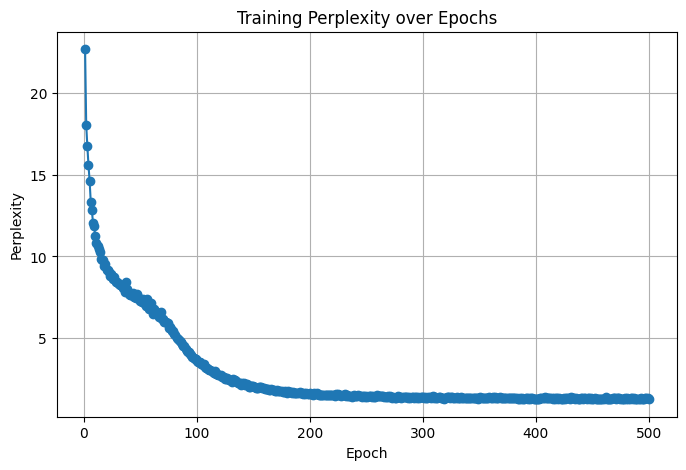

In [19]:
import torch
import torch.nn as nn
import math
import time
import matplotlib.pyplot as plt

# ==================================================================
# 1. 必需的辅助函数 (替代 d2l 的功能)
# ==================================================================

def grad_clipping(net, theta):
    """裁剪梯度 (使用PyTorch内置函数实现)"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
        torch.nn.utils.clip_grad_norm_(params, theta)

def predict_ch8(prefix, num_preds, net, vocab, device):
    """在prefix后面生成新字符"""
    # 将网络设置为评估模式
    net.eval()
    # 初始化隐藏状态
    state = net.begin_state(batch_size=1, device=device)
    # 将前缀文本转换为数字索引
    outputs = [vocab[prefix[0]]]
    # 预热阶段：用前缀来更新隐藏状态
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    # 预测阶段：生成 num_preds 个新字符
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
        
    # 将生成的数字索引转换回文本
    return ''.join([vocab.to_tokens(i) for i in outputs])

# ==================================================================
# 2. 合并后的主训练函数
# ==================================================================

def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
                         use_random_iter=False):
    """
    训练语言模型 (不依赖d2l库的整合版本)

    :param net: 神经网络模型 (nn.Module)
    :param train_iter: 训练数据迭代器
    :param vocab: 词汇表对象
    :param lr: 学习率
    :param num_epochs: 训练周期数
    :param device: 训练设备 (cpu, cuda, mps)
    :param use_random_iter: 是否使用随机采样迭代器
    """
    # --- 初始化 ---
    print(f"开始在 {device} 上训练...")
    loss = nn.CrossEntropyLoss()
    updater = torch.optim.SGD(net.parameters(), lr)
    
    # 用于存储每个epoch的困惑度，以供最后绘图
    history = []

    # --- 训练循环 ---
    for epoch in range(num_epochs):
        # --- 单个迭代周期的逻辑 (原 train_epoch_ch8) ---
        state, timer_start = None, time.time()
        
        # 替代 d2l.Accumulator
        total_loss = 0.0
        total_tokens = 0
        
        # 将网络设置为训练模式
        net.train()

        for X, Y in train_iter:
            # 初始化或分离隐藏状态
            if state is None or use_random_iter:
                state = net.begin_state(batch_size=X.shape[0], device=device)
            else:
                if isinstance(state, tuple): # for LSTM
                    for s in state:
                        s.detach_()
                else: # for GRU
                    state.detach_()

            # 准备数据和标签
            y = Y.T.reshape(-1)
            X, y = X.to(device), y.to(device)
            
            # 前向传播和计算损失
            y_hat, state = net(X, state)
            l = loss(y_hat, y.long()).mean()
            
            # 反向传播和更新参数
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1) # 梯度裁剪
            updater.step()
            
            # 累加损失和词元数量
            total_loss += l.item() * y.numel()
            total_tokens += y.numel()

        # --- epoch结束后的计算和打印 ---
        elapsed_time = time.time() - timer_start
        # 计算困惑度 (Perplexity)
        ppl = math.exp(total_loss / total_tokens)
        speed = total_tokens / elapsed_time
        
        # 将结果存入列表
        history.append((epoch + 1, ppl))
        
        # 每10个epoch打印一次预测结果
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Perplexity {ppl:.1f}, "
                  f"Speed {speed:.1f} tokens/sec")
            # 调用我们自己实现的预测函数
            print("  预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))

    # --- 训练结束后的总结和绘图 ---
    final_ppl = history[-1][1]
    print(f'\n训练完成。最终困惑度 {final_ppl:.1f}, {speed:.1f} 词元/秒 on {str(device)}')
    print("最终预测 'time traveller':", predict_ch8('time traveller', 50, net, vocab, device))
    print("最终预测 'traveller':", predict_ch8('traveller', 50, net, vocab, device))
    
    # --- 使用 Matplotlib 绘图 ---
    print("\n正在生成困惑度曲线图...")
    epochs, perplexities = zip(*history) # 解包历史记录
    
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, perplexities, marker='o', linestyle='-')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training Perplexity over Epochs')
    plt.grid(True)
    plt.show()

num_epochs, lr = 500, 1
net = RNNModel(rnn_layer, vocab_size=len(vocab))
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
net = net.to(device)
train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False)

In [15]:
num_inputs, num_hiddens, num_layers = 16, 256, 1

lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)

# 生成测试数据
batch_size, num_steps = 4, 5
X = torch.rand((num_steps, batch_size, num_inputs))
state = (torch.zeros((num_layers, batch_size, num_hiddens)),
         torch.zeros((num_layers, batch_size, num_hiddens)))

Y, state_new = lstm_layer(X, state)

X.shape, Y.shape, state_new[0].shape, state_new[1].shape

(torch.Size([5, 4, 16]),
 torch.Size([5, 4, 256]),
 torch.Size([1, 4, 256]),
 torch.Size([1, 4, 256]))